In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob
import numpy.ma as ma

import gsw as sw
from mpl_toolkits.basemap import Basemap, cm, interp

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})

import scipy.stats as st

In [2]:
# import data

maxlon = 171
minlon = 130

Tok1 = pd.read_csv('../data/filtered_O2Ar/Tokyo1_filt_vOct17.csv', sep=',')
Tok1['density'] = sw.rho(Tok1['S'].values,Tok1['T'].values,0)
Tok1 = Tok1[(Tok1['Lon']>minlon) & (Tok1['Lon']<maxlon)]

# Tok1['dlat'] = np.insert(np.diff(Tok1['Lat']), 0, 0)
# Tok1 = Tok1[np.abs(Tok1['dlat'])<0.08]

Tok3 = pd.read_csv('../data/filtered_O2Ar/Tokyo3_filt_vOct17.csv', sep=',')
Tok3['density'] = sw.rho(Tok3['S'].values,Tok3['T'].values,0)
Tok3 = Tok3[(Tok3['Lon']>minlon) & (Tok3['Lon']<maxlon)]

Tian = pd.read_csv('../data/filtered_O2Ar/Tianjin2_filt_vOct17.csv',sep=',')
Tian['density'] = sw.rho(Tian['S'].values,Tian['T'].values,0)
Tian = Tian[(Tian['Lon']>minlon) & (Tian['Lon']<maxlon)]

print Tian.columns

Index([u'Timestamp', u'Lat', u'Lon', u'S', u'T', u'Fluo', u'TrueO2Ar',
       u'O2Arsat', u'O2Arbiosat', u'MLD (WOA13)', u'Wkn', u'Air-sea flux',
       u'density'],
      dtype='object')


In [3]:
# import SSH data

files = glob.glob('../data/sla/*.nc')
#print files

Tok1_SSH = Dataset(files[0], mode='r')

slaT = ma.getdata(np.squeeze(Tok1_SSH.variables['sla'][:]))

lons = Tok1_SSH.variables['lon'][:]
lats = Tok1_SSH.variables['lat'][:]

ncp = Tok1['Air-sea flux'].values
temp = Tok1['T'].values

Tok1_SSH.close()

temp_track = []
ncp_track = []
sla_track = []
new_lat = []
spacing = 0.25

x = lons
y = lats

xnew = Tok1['Lon'].values
ynew = Tok1['Lat'].values

x = np.arange(140, 160.25, 0.25)

for n in range(len(x)):
    
    k = np.where((xnew < (x[n] + (spacing*0.5))) & (xnew > (x[n] - (spacing*0.5))))   
    l = np.mean(ynew[k])
    m = np.mean(ncp[k])
    o = np.mean(temp[k])
    
    # now need to find SLA value to coincide with NCP
    ll = np.where((lats>=(l - (spacing*0.5))) & (lats<=(l + (spacing*0.5))))
    mm = np.where((lons>=(x[n] - (spacing*0.5))) & (lons<(x[n] + (spacing*0.5))))
   
    ss = np.asscalar(np.mean(np.squeeze(slaT[ll,mm][0])))

    if np.isfinite(m) & np.isfinite(l):
        ncp_track.append(m)
        temp_track.append(o)
        new_lat.append(l)
        sla_track.append(ss)
    else:
        ncp_track.append(np.nan)
        temp_track.append(np.nan)
        new_lat.append(np.nan)
        sla_track.append(np.nan)

    #print xnew[n], ynew[n], k, l, m

#plt.scatter(sla_track, ncp_track, s = 20, lw = 0)

dtab = pd.DataFrame()
dtab['sla'] = sla_track
dtab['ncp'] = ncp_track
dtab['lat'] = new_lat
dtab['temp'] = temp_track 
dtabT1 = dtab.dropna()

mx, cx, rx, px, std_err = st.linregress(dtabT1['sla'], dtabT1['ncp'])
print 'estimated slope = ', mx, ', r = ', rx, ', p-value < 0.05 ', px

subset1 = dtabT1[dtabT1['temp']<18]

mx, cx, rx, px, std_err = st.linregress(subset1['sla'], subset1['ncp'])
print 'estimated slope = ', mx, ', r = ', rx, ', p-value < 0.05 ', px<0.05

subset = dtabT1[dtabT1['temp']>18]

mxtt, cxtt, rxtt, pxtt, std_errtt = st.linregress(subset['sla'], subset['ncp'])
print 'estimated slope = ', mxtt, ', r = ', rxtt, ', p-value < 0.05 ', pxtt

dtabT1.corr()

estimated slope =  -11.381984678462693 , r =  -0.10702404983373494 , p-value < 0.05  0.38141883569767876
estimated slope =  -171.49408042387333 , r =  -0.7627497108123472 , p-value < 0.05  True
estimated slope =  25.681724187404942 , r =  0.4425508298421565 , p-value < 0.05  0.05070408611255043


/Users/sclayton/miniconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/sclayton/miniconda2/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sclayton/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/Users/sclayton/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal


,sla,ncp,lat,temp
sla,1.000000,-0.107024,-0.430844,0.624903
ncp,-0.107024,1.000000,-0.607660,0.509418
lat,-0.430844,-0.607660,1.000000,-0.923622
temp,0.624903,0.509418,-0.923622,1.000000


In [4]:
Tok3_SSH = Dataset(files[2], mode='r')
slaT = np.squeeze(Tok3_SSH.variables['sla'][:])
lons = Tok3_SSH.variables['lon'][:]
lats = Tok3_SSH.variables['lat'][:]

ncp = Tok3['Air-sea flux'].values
temp = Tok3['T'].values

Tok3_SSH.close()

temp_track = []
ncp_track = []
sla_track = []
new_lat = []
spacing = 0.25

x = lons
y = lats

xnew = Tok3['Lon'].values
ynew = Tok3['Lat'].values

x = np.arange(140, 160.25, 0.25)

for n in range(len(x)):
    
    k = np.where((xnew < (x[n] + (spacing*0.5))) & (xnew > (x[n] - (spacing*0.5))))   
    l = np.mean(ynew[k])
    m = np.mean(ncp[k])
    p = np.mean(temp[k])
    
    # now need to find SLA value to coincide with NCP
    ll = np.where((lats>=(l - (spacing*0.5))) & (lats<=(l + (spacing*0.5))))
    mm = np.where((lons>=(x[n] - (spacing*0.5))) & (lons<(x[n] + (spacing*0.5))))
   
    ss = np.asscalar(np.mean(np.squeeze(slaT[ll,mm][0])))

    if np.isfinite(m) & np.isfinite(l):
        temp_track.append(p)
        ncp_track.append(m)
        new_lat.append(l)
        sla_track.append(ss)
    else:
        ncp_track.append(np.nan)
        temp_track.append(np.nan)
        new_lat.append(np.nan)
        sla_track.append(np.nan)

    #print xnew[n], ynew[n], k, l, m

#plt.scatter(sla_track, ncp_track, s = 20, lw = 0)


dtab = pd.DataFrame()
dtab['sla'] = sla_track
dtab['ncp'] = ncp_track
dtab['lat'] = new_lat
dtab['temp'] = temp_track
dtabT3 = dtab.dropna()

mx3, cx3, rx3, px3, std_err3 = st.linregress(dtabT3['sla'], dtabT3['ncp'])
print 'estimated slope = ', mx3, ', r = ', rx3, ', p-value < 0.05 ', px3<0.05

# plt.plot(np.arange(-0.6, 0.8, 0.01), mx*np.arange(-0.6, 0.8, 0.01)+cx, 'r')
# plt.show()


estimated slope =  -21.408021736810856 , r =  -0.4952267300063459 , p-value < 0.05  True


/Users/sclayton/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater_equal
/Users/sclayton/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less_equal


In [5]:
T_SSH = Dataset(files[5], mode='r')
slaT = np.squeeze(T_SSH.variables['sla'][:])
lons = T_SSH.variables['lon'][:]
lats = T_SSH.variables['lat'][:]

ncp = Tian['Air-sea flux'].values
temp = Tian['T'].values

T_SSH.close()

temp_track = []
ncp_track = []
sla_track = []
new_lat = []
spacing = 0.25

x = lons
y = lats

xnew = Tian['Lon'].values
ynew = Tian['Lat'].values

x = np.arange(140, 160.25, 0.25)

for n in range(len(x)):
    
    k = np.where((xnew < (x[n] + (spacing*0.5))) & (xnew > (x[n] - (spacing*0.5))))   
    l = np.mean(ynew[k])
    m = np.mean(ncp[k])
    p = np.mean(temp[k])
    
    # now need to find SLA value to coincide with NCP
    ll = np.where((lats>=(l - (spacing*0.5))) & (lats<=(l + (spacing*0.5))))
    mm = np.where((lons>=(x[n] - (spacing*0.5))) & (lons<(x[n] + (spacing*0.5))))
   
    ss = np.asscalar(np.mean(np.squeeze(slaT[ll,mm][0])))

    if np.isfinite(m) & np.isfinite(l):
        temp_track.append(p)
        ncp_track.append(m)
        new_lat.append(l)
        sla_track.append(ss)
    else:
        ncp_track.append(np.nan)
        temp_track.append(np.nan)
        new_lat.append(np.nan)
        sla_track.append(np.nan)

    #print xnew[n], ynew[n], k, l, m

#plt.scatter(new_lat, ncp_track, s = 20, lw = 0)

dtab = pd.DataFrame()
dtab['sla'] = sla_track
dtab['ncp'] = ncp_track
dtab['lat'] = new_lat
dtab['temp'] = temp_track
dtabTian = dtab.dropna()

mxt, cxt, rxt, pxt, std_errt = st.linregress(dtabTian['sla'], dtabTian['ncp'])
print 'estimated slope = ', mxt, ', r = ', rxt, ', p-value < 0.05 ', pxt<0.05

# #plt.plot(np.arange(34, 42, 0.5), mx*np.arange(34, 42, 0.5)+cx, 'r')
# plt.show()


subset1 = dtabTian[dtabTian['temp']<18]

mxst, cxst, rxst, pxst, std_errst = st.linregress(subset1['sla'], subset1['ncp'])
print 'estimated slope = ', mxst, ', r = ', rxst, ', p-value < 0.05 ', pxst<0.05

subset = dtabTian[dtabTian['temp']>18]

mxss, cxss, rxss, pxss, std_errss = st.linregress(subset['sla'], subset['ncp'])
print 'estimated slope = ', mxss, ', r = ', rxss, ', p-value < 0.05 ', pxss<0.05

print subset1.corr()
print subset.corr()

estimated slope =  46.857553360405824 , r =  0.47395521760101544 , p-value < 0.05  True
estimated slope =  -97.05194038559993 , r =  -0.43804366548361556 , p-value < 0.05  False
estimated slope =  14.758814042311869 , r =  0.29702993246845405 , p-value < 0.05  True
           sla       ncp       lat      temp
sla   1.000000 -0.438044 -0.121093  0.676417
ncp  -0.438044  1.000000 -0.037215 -0.337288
lat  -0.121093 -0.037215  1.000000 -0.560494
temp  0.676417 -0.337288 -0.560494  1.000000
           sla       ncp       lat      temp
sla   1.000000  0.297030  0.091474  0.096805
ncp   0.297030  1.000000  0.359534 -0.356520
lat   0.091474  0.359534  1.000000 -0.897674
temp  0.096805 -0.356520 -0.897674  1.000000


/Users/sclayton/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater_equal
/Users/sclayton/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less_equal


/Users/sclayton/miniconda2/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


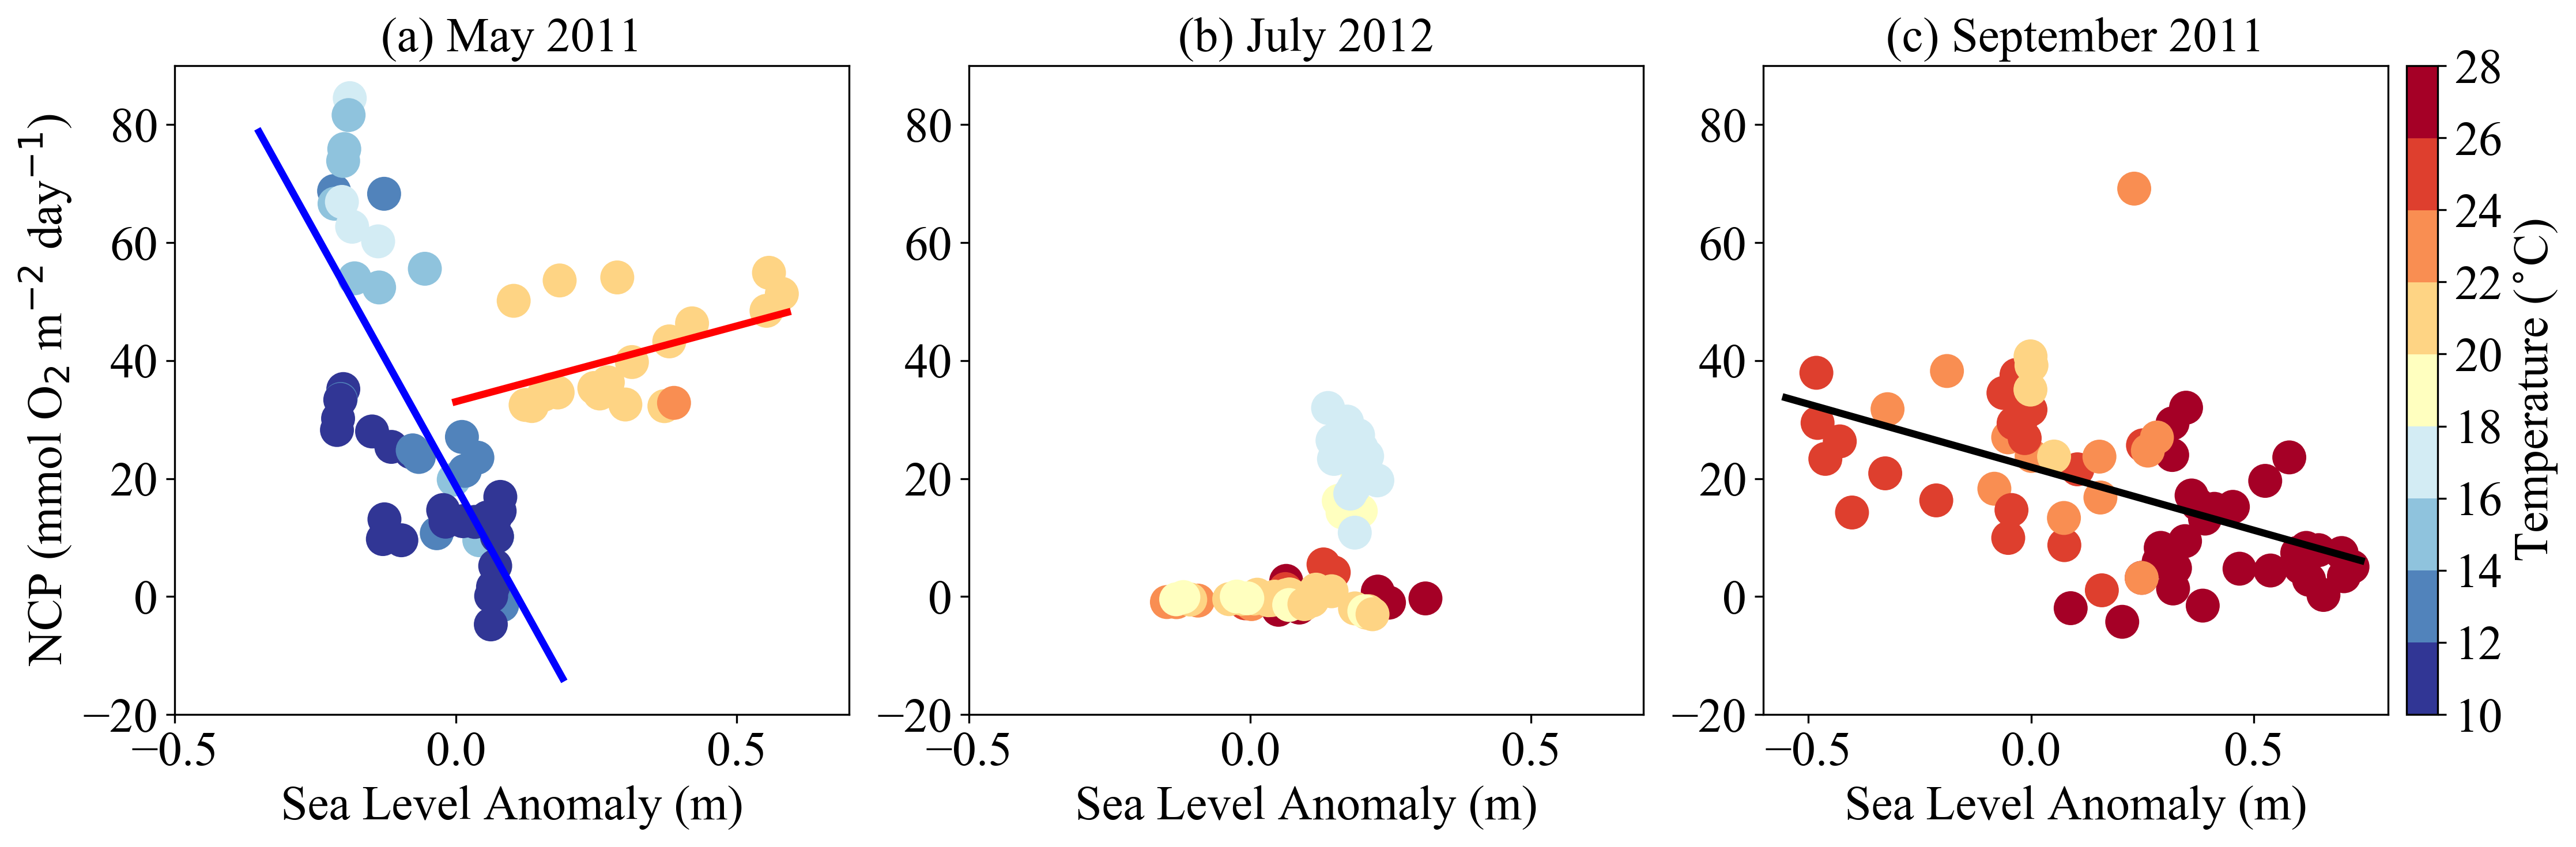

In [6]:
# make a 3 panel plot showing the relationship for each cruise between SLA and NCP
palette = plt.get_cmap('RdYlBu_r', 9)
fig1, (ax1, ax3, ax2) = plt.subplots(1, 3, figsize = (15, 5), dpi = 300)
#fig1, (ax1, ax3) = plt.subplots(1, 2, figsize = (12, 6), dpi = 300)

nn = 20

ax1.scatter(dtabT1['sla'], dtabT1['ncp'], s=200, c=dtabT1['temp'] , lw = 0, cmap = palette, vmin = 10, vmax = 28)
ax1.plot(np.arange(-0.35, 0.2, 0.01), mx*np.arange(-0.35, 0.2, 0.01)+cx, color = 'blue', lw =3)
ax1.plot(np.arange(0.0, 0.6, 0.01), mxtt*np.arange(0.0, 0.6, 0.01)+cxtt, color = 'r', lw =3)

ax1.set_xlim([-0.5, 0.7])
ax1.set_ylim([-20, 90])
ax1.set_ylabel('NCP (mmol O$_2$ m$^{-2}$ day$^{-1}$)', fontsize=nn)
ax1.set_xlabel('Sea Level Anomaly (m)', fontsize = nn)
ax1.set_title('(a) May 2011', fontsize = nn)
ax1.tick_params(labelsize = nn)

# ax2.scatter(dtabT3['sla'], dtabT3['ncp'], '.k', lw = 0, markersize = 10)
ax2.scatter(dtabT3['sla'], dtabT3['ncp'], s=200, c=dtabT3['temp'] , lw = 0, cmap = palette, vmin = 10, vmax = 28)

ax2.set_xlim([-0.6, 0.8])
ax2.set_ylim([-20, 90])
ax2.set_xlabel('Sea Level Anomaly (m)', fontsize=nn)
ax2.set_title('(c) September 2011', fontsize = nn)
ax2.tick_params(labelsize = nn)

ax2.plot(np.arange(-0.55, 0.75, 0.01), mx3*np.arange(-0.55, 0.75, 0.01)+cx3, 'k', lw =3)


ss = ax3.scatter(dtabTian['sla'], dtabTian['ncp'], s=200, c=dtabTian['temp'], lw = 0, cmap = palette, vmin = 10, vmax = 28)
ax3.set_xlim([-0.5, 0.7])
ax3.set_ylim([-20, 90])
ax3.set_title('(b) July 2012', fontsize = nn)
ax3.tick_params(labelsize = nn)
ax3.set_xlabel('Sea Level Anomaly (m)', fontsize = nn)

# ax3.plot(np.arange(-0.2, 0.4, 0.01), mx*np.arange(-0.2, 0.4, 0.01)+cxst, 'k', lw =3)


# fig1.subplots_adjust(right=0.8)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
cb = plt.colorbar(ss, cax=cax)

plt.tight_layout()

# cbar_ax = fig1.add_axes([1.0, 0.12, 0.02, 0.82])
# cb = plt.colorbar(ss, cax=cbar_ax)
cb.set_label('Temperature ($^{\circ}$C)', fontsize = nn)
cb.ax.tick_params(labelsize=nn)
fig1.tight_layout()
plt.show()

# fig1.savefig('../manuscript/Figure4.png', dpi = 300)

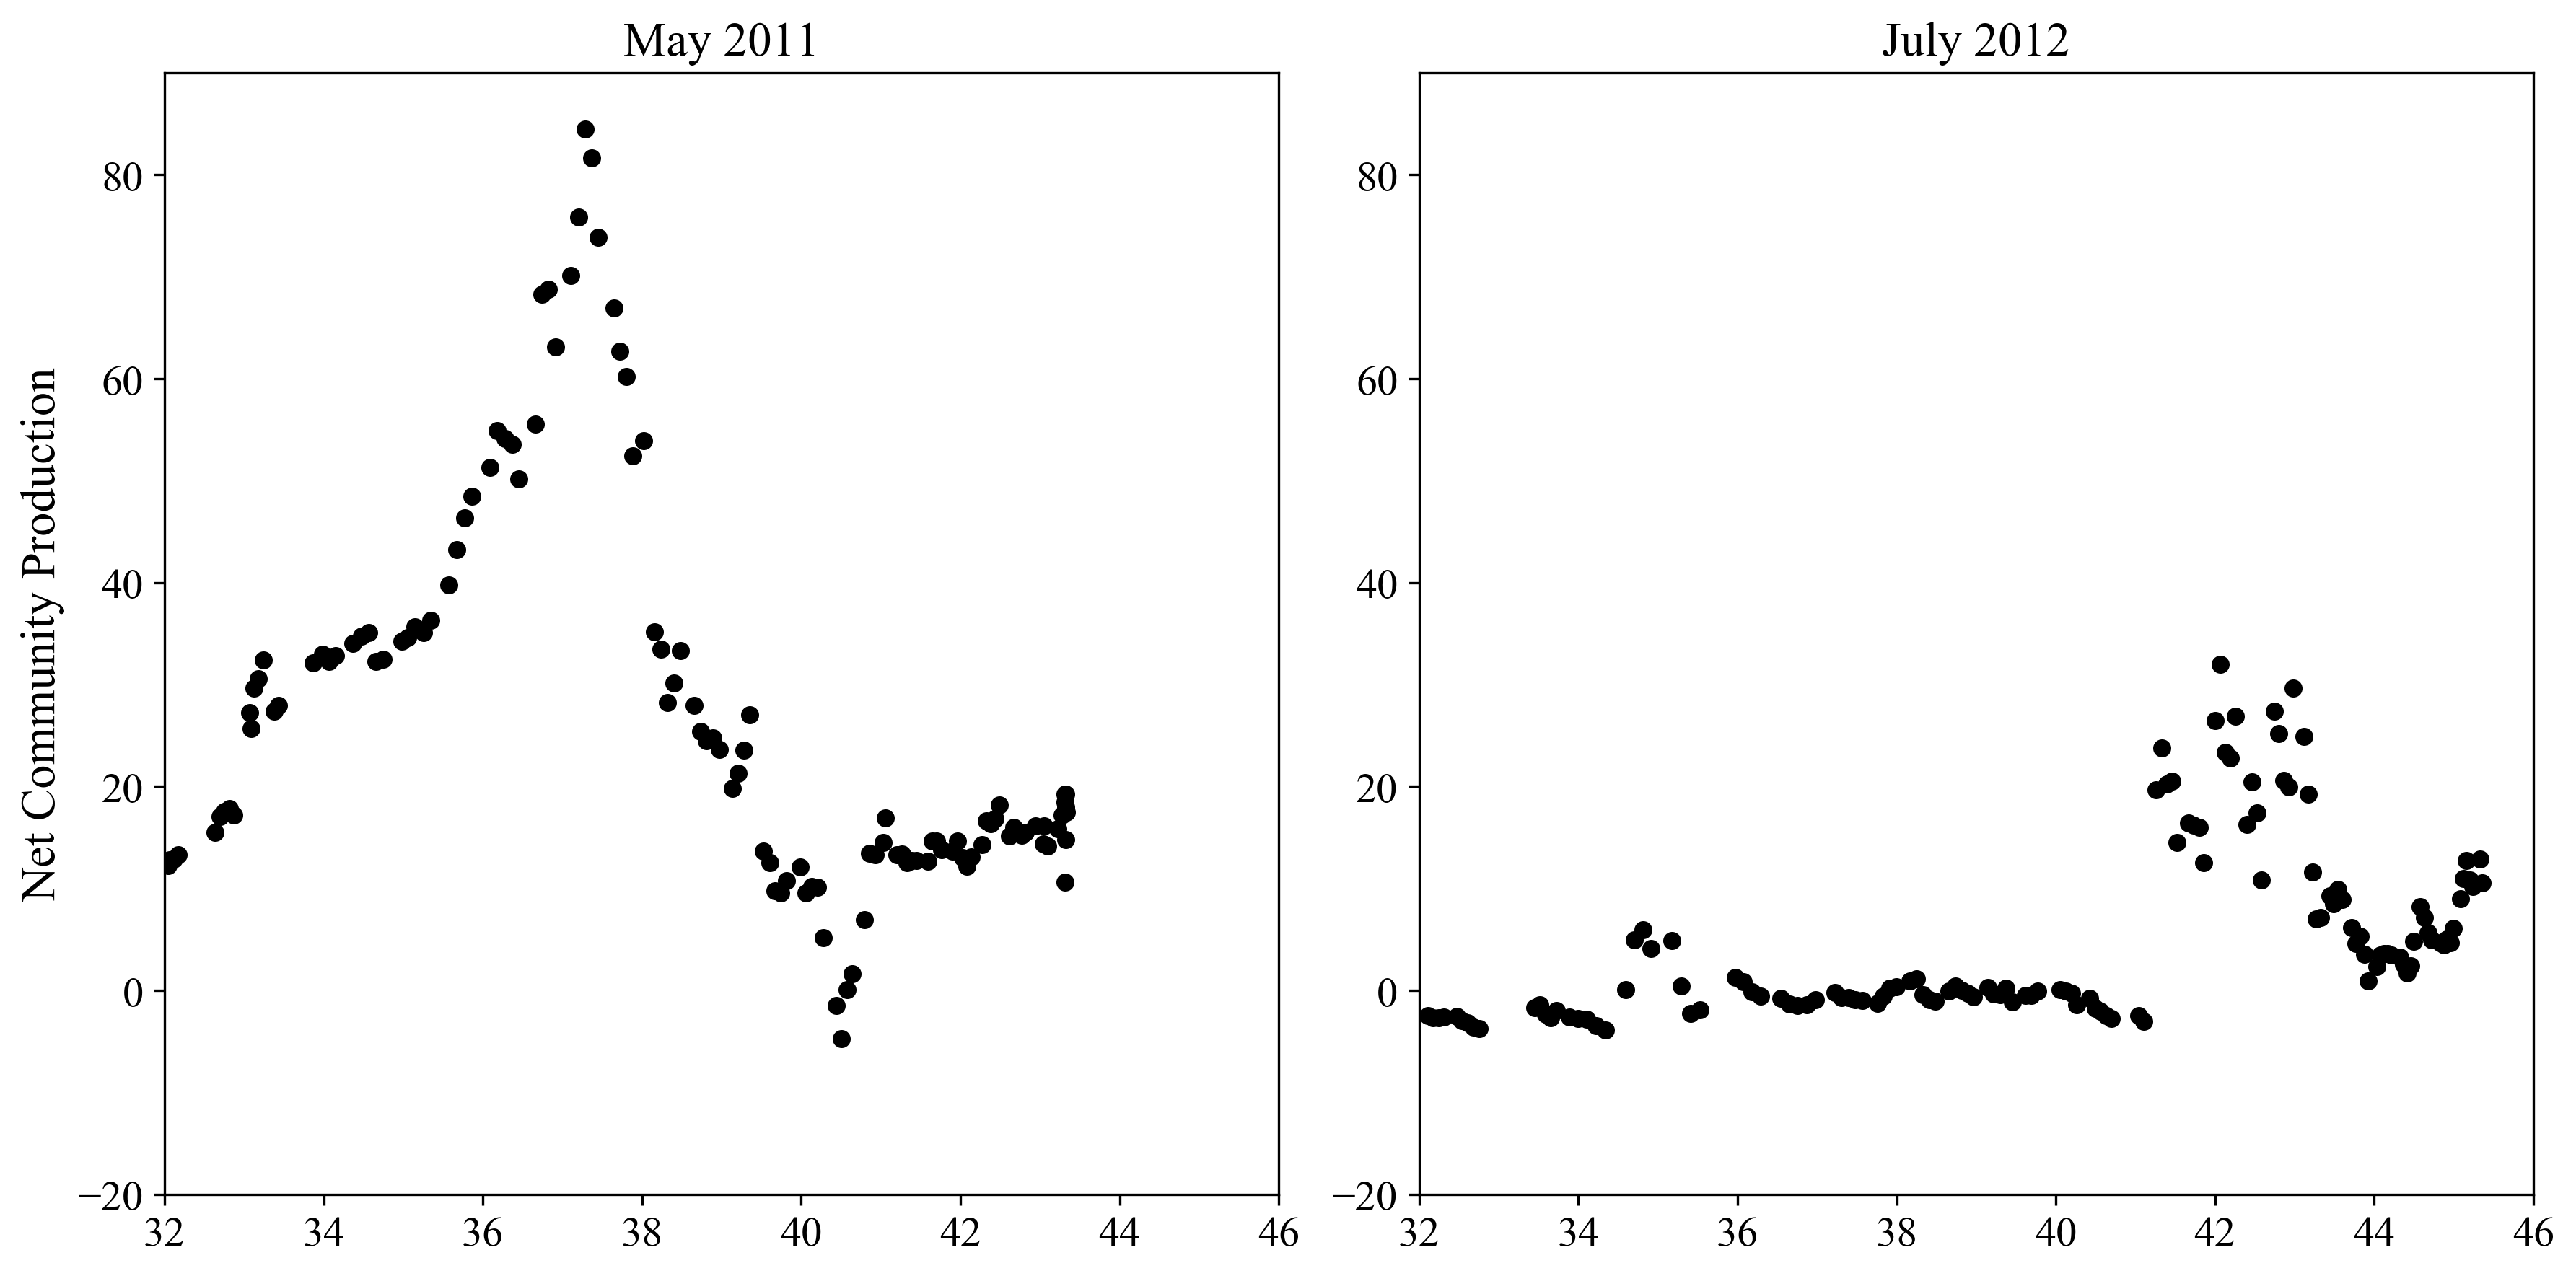

In [7]:
# make a 3 panel plot showing the relationship for each cruise between SLA and NCP

# fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4), dpi = 300)
fig2, (ax1, ax3) = plt.subplots(1, 2, figsize = (12, 6), dpi = 300)


ax1.plot(Tok1['Lat'], Tok1['Air-sea flux'], '.k', lw = 0, markersize = 10)
ax1.set_xlim([32, 46])
ax1.set_ylim([-20, 90])
ax1.set_ylabel('Net Community Production', fontsize=16)
ax1.set_title('May 2011', fontsize = 16)
ax1.tick_params(labelsize = 14)

# ax2.plot(Tok3['Lat'], Tok3['Air-sea flux'], '.k', lw = 0, markersize = 10)
# ax2.set_xlim([32, 46])
# ax2.set_ylim([-20, 90])
# ax2.set_xlabel('Latitude ($^o$)', fontsize=16)
# ax2.set_title('September 2011', fontsize = 16)
# ax2.tick_params(labelsize = 14)

ax3.plot(Tian['Lat'], Tian['Air-sea flux'], '.k', lw = 0, markersize = 10)
ax3.set_xlim([32, 46])
ax3.set_ylim([-20, 90])
ax3.set_title('July 2012', fontsize = 16)
ax3.tick_params(labelsize = 14)

plt.show()

#fig2.savefig('../figures/NCP_LAT_scatter.png', dpi = 300)

In [ ]:
# import MDT data

infile = '../data/mdt/mdt_cnes_cls2013_global.nc'
mdt_data = Dataset(infile, mode='r')

mdt_data.variables

mdt = np.squeeze(mdt_data.variables['mdt'])
lats = mdt_data.variables['lat'][:]
lons = mdt_data.variables['lon'][:]

lon_mdt, lat_mdt = np.meshgrid(lons, lats)
